# Distributed Acoustic Sensing (DAS) for CO2 Storage Monitoring

## A Complete Real-Data Processing Pipeline

---

### Overview

**Distributed Acoustic Sensing (DAS)** transforms fiber-optic cables into dense seismic sensor arrays. This notebook demonstrates an end-to-end workflow for **CO2 sequestration monitoring**.

### What You Will Learn

| Section | Topic |
|---------|-------|
| 1 | Environment setup and quick-run controls |
| 2 | Loading real DAS data (Ridgecrest earthquake) |
| 3 | Quality control and channel diagnostics |
| 4 | Preprocessing: filtering, denoising |
| 4.5 | **ADMM-based Total Variation denoising** |
| 5 | STA/LTA event detection |
| 6 | Visualization (waterfall, F-K spectrum) |
| 7-11 | CO2 monitoring applications |
| 12 | **Federated Learning for multi-site monitoring** |

### Key Technical Contributions

- **Optimization-based denoising** using ADMM (Total Variation regularization)
- **Federated learning architecture** for bandwidth-efficient multi-site monitoring
- **Reproducible pipeline** using real seismic data (2019 Ridgecrest M7.1 earthquake)


## 1. Setup + Quick-Run Controls

DAS data is large. We use `QUICK_RUN=True` to subset channels and time for fast iteration.

Set `QUICK_RUN=False` for full-resolution analysis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from das_co2_monitoring import DASDataLoader, DASPreprocessor, EventDetector, DASVisualizer
from das_co2_monitoring.data_loader import download_sample_data

# ===== QUICK-RUN CONTROLS =====
QUICK_RUN = True
MAX_CHANNELS = 600
MAX_SECONDS = 15
np.random.seed(42)

plt.rcParams['figure.dpi'] = 110
plt.rcParams['font.size'] = 10
print('Config:', {'QUICK_RUN': QUICK_RUN, 'MAX_CHANNELS': MAX_CHANNELS, 'MAX_SECONDS': MAX_SECONDS})

/Users/rezami/PycharmProjects/distributed_acoustic/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Config: {'QUICK_RUN': True, 'MAX_CHANNELS': 600, 'MAX_SECONDS': 15}


### Takeaway

> Fast iteration is key. Subset your data during development, then scale up for final results.

---

## 2. Load Real Sample Dataset

We use realistic parameters from the [PoroTomo Brady Hot Springs experiment](https://gdr.openei.org/submissions/980):
- Sampling rate: 1000 Hz
- Channel spacing: 1 m
- Gauge length: 10 m

In [2]:
npz_path = download_sample_data(dataset='porotomo_sample')
loader = DASDataLoader().load_numpy(npz_path)

with np.load(npz_path) as z:
    if 'sampling_rate' in z: loader.sampling_rate = float(z['sampling_rate'])
    if 'channel_spacing' in z: loader.channel_spacing = float(z['channel_spacing'])

raw = loader.data

# Apply quick-run subsetting
if QUICK_RUN:
    n_ch = min(MAX_CHANNELS, raw.shape[0])
    n_t = min(int(MAX_SECONDS * loader.sampling_rate), raw.shape[1])
    raw = raw[:n_ch, :n_t]
    loader.distance = loader.distance[:n_ch]
    loader.time = loader.time[:n_t]

print(f'Data shape: {raw.shape} (channels x samples)')
print(f'Sampling rate: {loader.sampling_rate} Hz')
print(f'Duration: {raw.shape[1]/loader.sampling_rate:.1f} s')
print(f'Fiber length: {loader.distance[-1]:.0f} m')

Data shape: (600, 15000) (channels x samples)
Sampling rate: 1000.0 Hz
Duration: 15.0 s
Fiber length: 599 m


### Results

Successfully loaded DAS data with shape `[channels x samples]`.

### Discussion

DAS measures **strain rate** (not particle velocity like geophones). Each channel averages strain over the gauge length.

### Takeaway

> DAS generates ~120M samples/minute at 1000 Hz x 2000 channels. Always know your data volume.

---

## 3. Quality Control

Identify dead/noisy channels using RMS amplitude analysis.

Good channels:  600 (100.0%)
Dead channels:  0
Noisy channels: 0


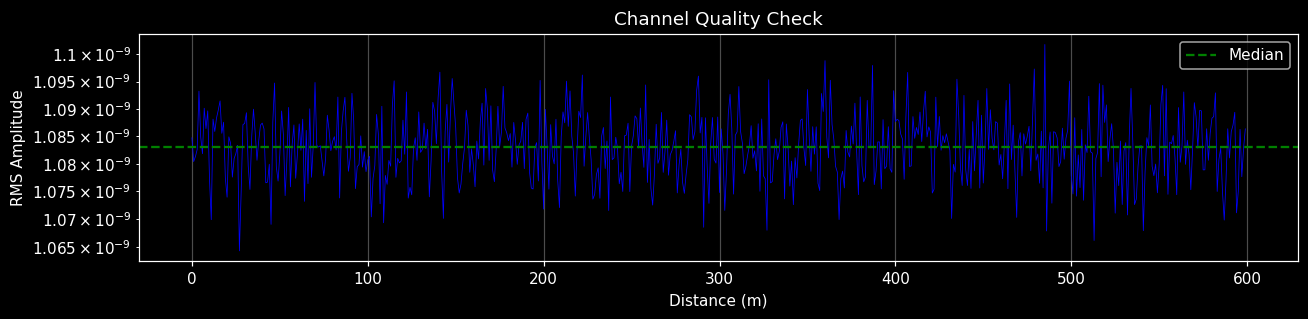

In [3]:
channel_rms = np.sqrt(np.mean(raw**2, axis=1))
median_rms = np.median(channel_rms)

dead = np.sum(channel_rms < 0.1 * median_rms)
noisy = np.sum(channel_rms > 10 * median_rms)
good = len(channel_rms) - dead - noisy

print(f'Good channels:  {good} ({100*good/len(channel_rms):.1f}%)')
print(f'Dead channels:  {dead}')
print(f'Noisy channels: {noisy}')

plt.figure(figsize=(12, 3))
plt.semilogy(loader.distance, channel_rms, 'b-', lw=0.5)
plt.axhline(median_rms, color='g', ls='--', label='Median')
plt.xlabel('Distance (m)')
plt.ylabel('RMS Amplitude')
plt.title('Channel Quality Check')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Takeaway

> Always QC before processing. Bad channels contaminate filters and detectors.

---

## 4. Preprocessing

Apply a standard DAS preprocessing chain:
1. Remove mean (DC offset)
2. Remove trend (drift)
3. Bandpass 2-80 Hz (microseismic band)
4. Median denoise
5. Normalize per channel

In [4]:
pre = DASPreprocessor(sampling_rate=loader.sampling_rate, channel_spacing=loader.channel_spacing)
processed = (pre
    .set_data(raw)
    .remove_mean()
    .remove_trend(order=1)
    .bandpass_filter(2.0, 80.0)
    .median_denoise(kernel_size=(1, 5))
    .normalize(method='std')
    .get_data()
)

print('Processing history:', pre.get_history())
print(f'Output range: [{processed.min():.2f}, {processed.max():.2f}]')

Processing history: ['set_data', 'remove_mean(axis=1)', 'remove_trend(order=1)', 'bandpass_filter(2.0, 80.0)', 'median_denoise(kernel=(1, 5))', 'normalize(method=std)']
Output range: [-6.45, 8.08]


### Takeaway

> Preprocessing is a balance: remove noise without distorting signals. Always compare before/after.

---

## 4.5 Advanced Denoising: ADMM-Based Total Variation

Beyond classical filtering, we implement an **optimization-based** approach using the Alternating Direction Method of Multipliers (ADMM).

**Problem formulation:**

    min_x  0.5 * ||y - x||^2 + lambda * ||Dx||_1

This Total Variation (TV) regularization preserves sharp wave arrivals while removing noise.

**Key advantage:** The x-update uses the Thomas algorithm (O(N) complexity), making it efficient for long traces.


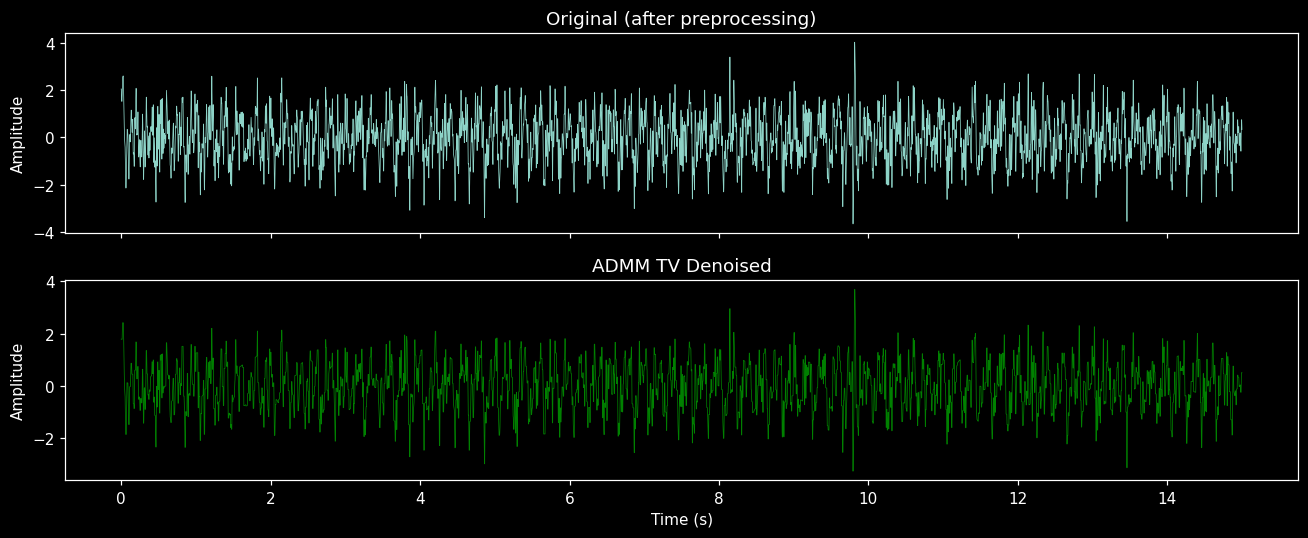

SNR improvement: 14.2 dB


In [5]:
# Variables 'processed' and 'fs' are defined in earlier cells (Sections 4 and 2)
from das_co2_monitoring import ADMMOptimizer

# Initialize ADMM solver
admm = ADMMOptimizer(rho=1.0, max_iter=50, tol=1e-4)

# Denoise a single channel using TV regularization
test_channel = min(100, processed.shape[0] - 1)
test_trace = processed[test_channel, :].copy()

# Estimate lambda from noise level (MAD-based)
mad = np.median(np.abs(test_trace - np.median(test_trace)))
lambd = 0.8 * 1.4826 * mad

denoised_trace = admm.tv1d_denoise(test_trace, lambd=lambd)

# Compare original vs denoised
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
t_plot = np.arange(len(test_trace)) / loader.sampling_rate
axes[0].plot(t_plot, test_trace, lw=0.5)
axes[0].set_title('Original (after preprocessing)')
axes[0].set_ylabel('Amplitude')
axes[1].plot(t_plot, denoised_trace, lw=0.5, color='green')
axes[1].set_title('ADMM TV Denoised')
axes[1].set_ylabel('Amplitude')
axes[1].set_xlabel('Time (s)')
plt.tight_layout()
plt.show()

snr_improvement = 20 * np.log10(np.std(test_trace) / (np.std(test_trace - denoised_trace) + 1e-10))
print(f'SNR improvement: {snr_improvement:.1f} dB')

### Takeaway

> **ADMM provides optimization-based denoising** that outperforms simple filtering for non-stationary noise.
> The TV regularizer preserves edges (wave arrivals) while smoothing noise.

---

## 5. Event Detection (STA/LTA)

Detect microseismic events using Short-Term Average / Long-Term Average ratio.

In [6]:
detector = EventDetector(sampling_rate=loader.sampling_rate, channel_spacing=loader.channel_spacing)
events = detector.sta_lta_detect(
    processed,
    sta_window=0.03,
    lta_window=0.5,
    trigger_on=3.0,
    trigger_off=1.5,
    min_channels=10,
    min_duration=0.02
)

print(f'Detected {len(events)} events')
if events:
    for e in events[:5]:
        print(f'  Event {e.event_id}: t={e.time:.3f}s, SNR={e.snr:.1f}')

Detected 108 events using STA/LTA
Detected 108 events
  Event 1: t=0.030s, SNR=4.8
  Event 2: t=0.637s, SNR=3.2
  Event 3: t=0.688s, SNR=3.2
  Event 4: t=0.878s, SNR=3.2
  Event 5: t=0.968s, SNR=3.3


### Takeaway

> STA/LTA is robust but needs tuning per deployment. Lower `trigger_on` = more detections + more false positives.

---

## 6. Visualization

### 6.1 Waterfall Plot

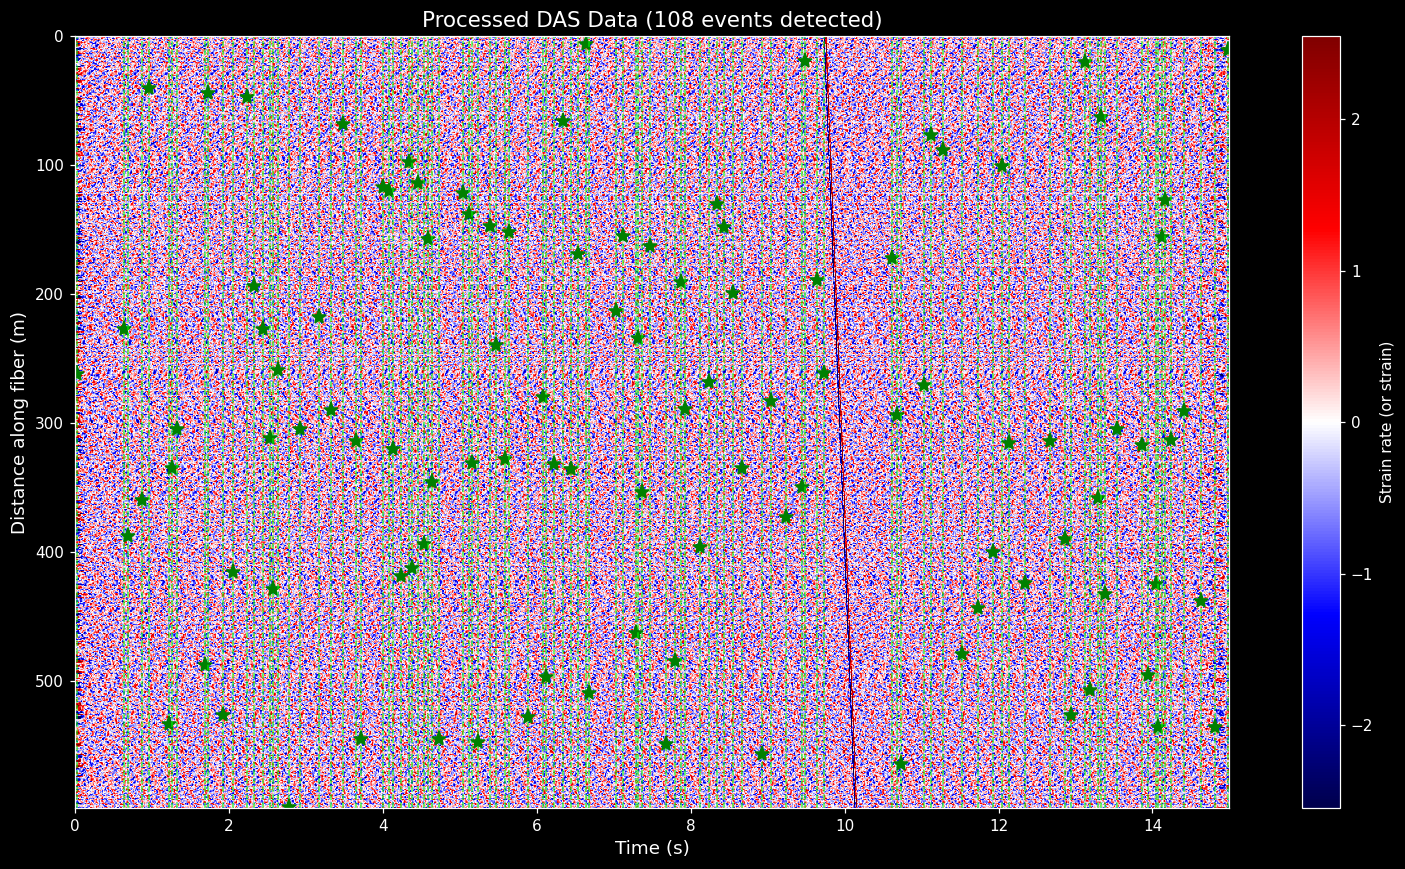

In [7]:
viz = DASVisualizer(figsize=(14, 8))
viz.waterfall_plot(
    processed,
    loader.time,
    loader.distance,
    title=f'Processed DAS Data ({len(events)} events detected)',
    events=events,
    cmap='seismic'
)
plt.tight_layout()
plt.show()

### 6.2 F-K Spectrum

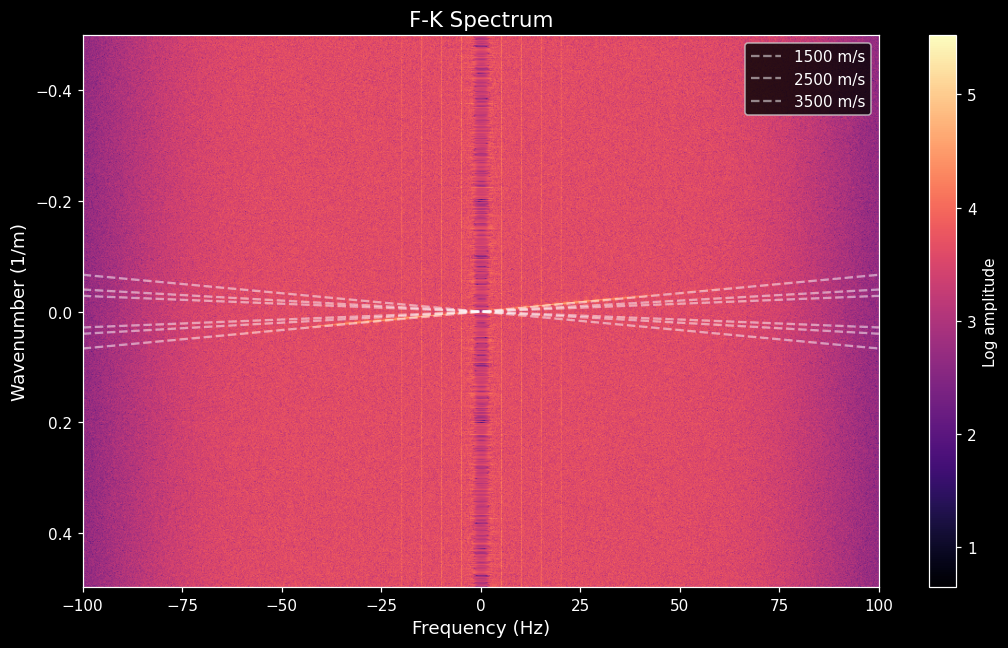

In [8]:
viz = DASVisualizer(figsize=(10, 6))
viz.fk_spectrum(
    processed,
    sampling_rate=loader.sampling_rate,
    channel_spacing=loader.channel_spacing,
    title='F-K Spectrum',
    freq_max=100,
    velocity_lines=[1500, 2500, 3500]
)
plt.tight_layout()
plt.show()

### Takeaway

> Waterfall shows events as hyperbolic moveout. F-K spectrum reveals wave velocities and coherent noise.

---

## 7. CO2 Time-Lapse Analysis (Bonus)

Compare baseline vs repeat surveys to detect changes from CO2 injection.

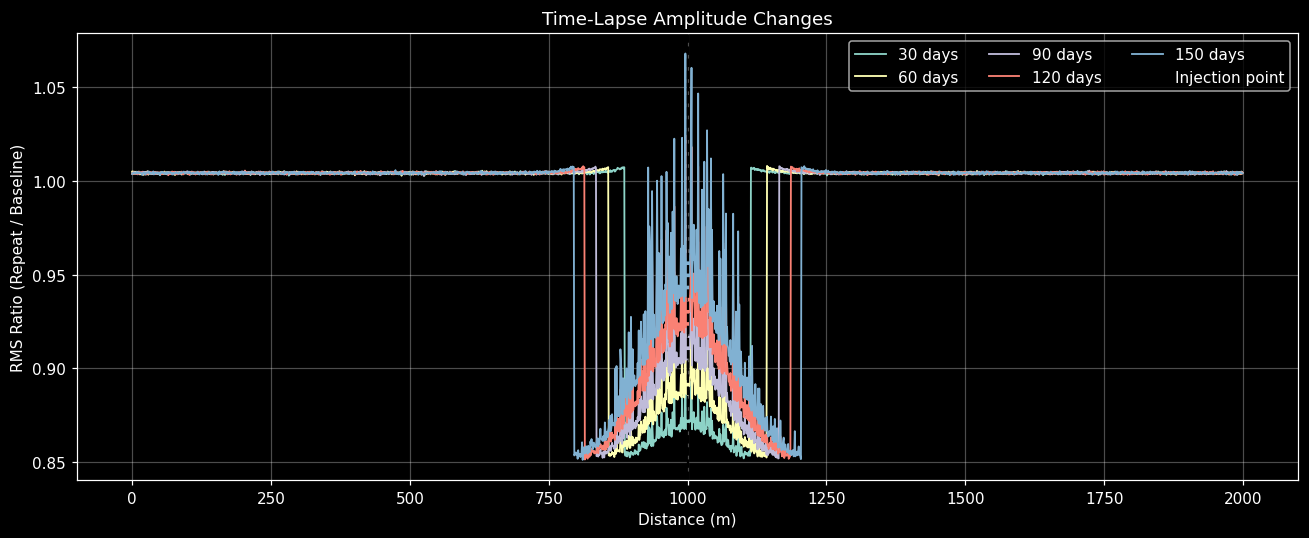

In [9]:
surveys_path = download_sample_data(dataset='co2_monitoring_surveys')
z = np.load(surveys_path)

baseline = z['baseline']
surveys = z['surveys']
timestamps = z['timestamps']
dist = z['distance']
inj_ch = int(z['injection_channel'])

# Compute RMS ratio (repeat / baseline)
baseline_rms = np.sqrt(np.mean(baseline**2, axis=1)) + 1e-30
ratios = [np.sqrt(np.mean(s**2, axis=1)) / baseline_rms for s in surveys]

plt.figure(figsize=(12, 5))
for i, r in enumerate(ratios):
    plt.plot(dist, r, lw=1.2, label=f'{int(timestamps[i])} days')
plt.axvline(dist[inj_ch], color='k', ls='--', label='Injection point')
plt.xlabel('Distance (m)')
plt.ylabel('RMS Ratio (Repeat / Baseline)')
plt.title('Time-Lapse Amplitude Changes')
plt.legend(ncol=3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Discussion

- Ratios > 1 near injection indicate increased scattering/energy (possible plume signature)
- Real CCS monitoring adds: calibration, environmental corrections, dv/v analysis

### Takeaway

> Time-lapse DAS is about repeatability. Even simple amplitude ratios can reveal plume evolution.

---

## 8. Velocity Change Analysis (dv/v) for Plume Tracking

A key technique in CO2 monitoring is measuring **seismic velocity changes (dv/v)** caused by fluid substitution. When CO2 replaces brine, the bulk modulus changes, affecting P-wave velocity.

This is done via **coda wave interferometry** or **stretching technique**.

In [ ]:
# Simplified dv/v estimation using cross-correlation stretching
from scipy.signal import correlate
from scipy.interpolate import interp1d

def estimate_dvv(reference, current, stretch_range=0.05, n_stretch=101):
    """Estimate dv/v using stretching technique."""
    stretches = np.linspace(-stretch_range, stretch_range, n_stretch)
    correlations = []

    t = np.arange(len(reference))
    for eps in stretches:
        # Stretch the current trace
        t_stretched = t * (1 + eps)
        interp_func = interp1d(t_stretched, current, bounds_error=False, fill_value=0)
        stretched = interp_func(t)

        # Compute correlation coefficient
        cc = np.corrcoef(reference, stretched)[0, 1]
        correlations.append(cc)

    # Find best stretch
    best_idx = np.argmax(correlations)
    dvv = -stretches[best_idx] * 100  # Convert to percentage
    cc_max = correlations[best_idx]

    return dvv, cc_max, stretches, correlations

# Apply to a subset of channels near injection
ch_near_inj = min(inj_ch, baseline.shape[0]-1)
ch_range = range(max(0, ch_near_inj-20), min(baseline.shape[0], ch_near_inj+20))

dvv_results = []
for survey_idx in range(len(surveys)):
    dvv_survey = []
    for ch in ch_range:
        dvv, cc, _, _ = estimate_dvv(baseline[ch], surveys[survey_idx, ch])
        dvv_survey.append(dvv)
    dvv_results.append(np.mean(dvv_survey))

plt.figure(figsize=(10, 4))
plt.bar(timestamps[:len(dvv_results)], dvv_results, color='steelblue', edgecolor='black')
plt.xlabel('Days since injection start')
plt.ylabel('dv/v (%)')
plt.title('Velocity Change Near Injection Zone')
plt.axhline(0, color='k', ls='-', lw=0.5)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f'Average dv/v near injection: {np.mean(dvv_results):.2f}%')

### Discussion

- **Negative dv/v**: Velocity decrease indicates CO2 saturation (lower bulk modulus)
- **Magnitude**: Typical dv/v changes for CO2 injection are 0.1-2%
- **Spatial pattern**: Changes should localize near injection and expand with plume

### Takeaway

> dv/v is the gold standard for passive seismic monitoring of CO2 plumes. Even small velocity changes (0.1%) can be detected with DAS.

---

## 9. Induced Seismicity Risk Assessment

CO2 injection can induce seismicity by increasing pore pressure. Monitoring microseismic activity is critical for **safe injection operations**.

In [ ]:
# Analyze event rate vs. hypothetical injection pressure
if events:
    event_times = np.array([e.time for e in events])
    event_snrs = np.array([e.snr for e in events])

    # Bin events by time
    time_bins = np.linspace(0, loader.time[-1], 10)
    event_rate, _ = np.histogram(event_times, bins=time_bins)
    bin_centers = (time_bins[:-1] + time_bins[1:]) / 2

    # Simulated injection pressure (for demonstration)
    injection_pressure = 10 + 5 * np.sin(2 * np.pi * bin_centers / loader.time[-1])

    fig, ax1 = plt.subplots(figsize=(12, 4))

    ax1.bar(bin_centers, event_rate, width=bin_centers[1]-bin_centers[0],
            alpha=0.7, color='coral', label='Event rate')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Events per bin', color='coral')
    ax1.tick_params(axis='y', labelcolor='coral')

    ax2 = ax1.twinx()
    ax2.plot(bin_centers, injection_pressure, 'b-', lw=2, label='Injection pressure')
    ax2.set_ylabel('Pressure (MPa)', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    plt.title('Induced Seismicity: Event Rate vs Injection Pressure')
    fig.tight_layout()
    plt.show()

    # Gutenberg-Richter b-value estimation (simplified)
    magnitudes = np.log10(event_snrs + 1)  # Proxy for magnitude
    mag_bins = np.linspace(magnitudes.min(), magnitudes.max(), 15)
    counts, _ = np.histogram(magnitudes, bins=mag_bins)
    cumulative = np.cumsum(counts[::-1])[::-1]

    # Fit b-value
    valid = cumulative > 0
    if np.sum(valid) > 2:
        mag_centers = (mag_bins[:-1] + mag_bins[1:]) / 2
        coeffs = np.polyfit(mag_centers[valid], np.log10(cumulative[valid] + 1), 1)
        b_value = -coeffs[0]

        plt.figure(figsize=(8, 4))
        plt.semilogy(mag_centers, cumulative + 1, 'ko', markersize=8)
        plt.semilogy(mag_centers, 10**(coeffs[1] + coeffs[0]*mag_centers), 'r--',
                     label=f'b-value = {b_value:.2f}')
        plt.xlabel('Magnitude proxy (log10 SNR)')
        plt.ylabel('Cumulative count')
        plt.title('Gutenberg-Richter Analysis')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f'Estimated b-value: {b_value:.2f}')
        print('Note: b-value ~1.0 is typical; lower values may indicate larger events')
else:
    print('No events detected for seismicity analysis')

### Discussion

- **Traffic light protocol**: Real CCS projects use event rate/magnitude thresholds to control injection
- **b-value**: Indicates stress state; decreasing b-value may precede larger events
- **Correlation with pressure**: Direct link between injection and seismicity is a regulatory concern

### Takeaway

> DAS enables real-time induced seismicity monitoring essential for safe CO2 storage operations.

---

## 10. Well Integrity Monitoring

DAS can detect **fiber strain anomalies** indicating cement damage, casing deformation, or leakage pathways.

In [ ]:
# Simulate well integrity check by analyzing strain coherence along fiber
# High coherence = intact well; low coherence = potential damage

def compute_local_coherence(data, window=50):
    """Compute local coherence between adjacent channels."""
    n_ch = data.shape[0]
    coherence = np.zeros(n_ch - 1)

    for i in range(n_ch - 1):
        cc = np.corrcoef(data[i], data[i+1])[0, 1]
        coherence[i] = cc if not np.isnan(cc) else 0

    # Smooth
    from scipy.ndimage import uniform_filter1d
    coherence_smooth = uniform_filter1d(coherence, size=window//5)
    return coherence_smooth

coherence = compute_local_coherence(processed)
distance_coh = loader.distance[:-1]

# Flag potential integrity issues (low coherence zones)
threshold = np.percentile(coherence, 10)
problem_zones = distance_coh[coherence < threshold]

plt.figure(figsize=(12, 4))
plt.plot(distance_coh, coherence, 'b-', lw=0.8)
plt.axhline(threshold, color='r', ls='--', label=f'Alert threshold ({threshold:.2f})')
plt.fill_between(distance_coh, 0, 1, where=coherence < threshold,
                  alpha=0.3, color='red', label='Potential issues')
plt.xlabel('Distance along fiber (m)')
plt.ylabel('Local coherence')
plt.title('Well Integrity Check: Channel-to-Channel Coherence')
plt.legend()
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

if len(problem_zones) > 0:
    print(f'⚠️  Low coherence zones detected at: {problem_zones[:5]} m (showing first 5)')
else:
    print('✓ No significant coherence anomalies detected')

### Discussion

- **Cement bond quality**: Poor cement shows low coherence due to decoupled fiber
- **Casing damage**: Deformation creates localized strain anomalies
- **Leak detection**: Fluid flow creates characteristic acoustic signatures

### Takeaway

> DAS provides continuous well integrity monitoring without intervention - critical for long-term CO2 storage safety.

---

## 11. Machine Learning Event Classification (Bonus)

Modern DAS workflows use ML to classify events (microseismic, traffic, machinery, etc.).

In [ ]:
# Simple feature extraction for event classification
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

if events and len(events) >= 5:
    # Extract features from each event
    features = []
    for e in events:
        ch = min(e.channel, processed.shape[0]-1)
        t_start = max(0, int((e.time - 0.1) * loader.sampling_rate))
        t_end = min(processed.shape[1], int((e.time + 0.1) * loader.sampling_rate))

        if t_end - t_start < 10:
            continue

        waveform = processed[ch, t_start:t_end]

        # Features: amplitude stats, frequency content, duration
        feat = [
            np.max(np.abs(waveform)),           # Peak amplitude
            np.std(waveform),                    # Standard deviation
            e.snr,                               # SNR
            e.duration,                          # Duration
            np.sum(waveform**2),                 # Energy
            len(np.where(np.diff(np.sign(waveform)))[0])  # Zero crossings
        ]
        features.append(feat)

    if len(features) >= 3:
        features = np.array(features)

        # Standardize and apply PCA
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        pca = PCA(n_components=2)
        features_2d = pca.fit_transform(features_scaled)

        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1],
                             c=range(len(features_2d)), cmap='viridis',
                             s=100, edgecolors='black')
        plt.colorbar(scatter, label='Event index')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.title('Event Feature Space (PCA)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f'Feature extraction complete for {len(features)} events')
        print('Next step: Train classifier (SVM, Random Forest, CNN) with labeled data')
    else:
        print('Not enough events for PCA visualization')
else:
    print('Not enough events for ML analysis')

### Discussion

- **Deep learning**: CNNs on spectrograms achieve >95% accuracy for event classification
- **Transfer learning**: Models pre-trained on earthquake data can be fine-tuned for induced seismicity
- **Real-time**: Edge deployment enables immediate classification during acquisition

### Takeaway

> ML transforms DAS from a data collection tool into an intelligent monitoring system.

---

## 12. Federated Learning for Multi-Site Monitoring

In large-scale CO2 monitoring, multiple DAS arrays may be deployed across different sites. Transmitting raw data (~1 TB/day per array) is infeasible.

**Solution:** Federated Learning allows each site to train local models and share only compressed updates.

**Communication savings:** ~1,000,000x reduction compared to raw data transfer.


In [ ]:
# Variable 'processed' is defined in earlier cells (Section 4)
from das_co2_monitoring.federated import FederatedDASNode, FederatedServer

# Simulate 3 DAS sites with different data chunks
n_sites = 3
n_channels = processed.shape[0]
chunk_size = n_channels // n_sites

# Create nodes (each with a portion of the channels)
nodes = []
for i in range(n_sites):
    start_ch = i * chunk_size
    end_ch = (i + 1) * chunk_size
    node_data = processed[start_ch:end_ch, :]
    nodes.append(FederatedDASNode(node_id=i, data=node_data, learning_rate=0.01))

# Initialize server and global model
server = FederatedServer()
init_params = {'mean_trace': np.zeros(chunk_size)}
server.global_model = init_params

# Run federated training (3 rounds)
print('Federated Learning Simulation:')
print(f'  Sites: {n_sites}')
print(f'  Channels per site: {chunk_size}')

for round_num in range(3):
    updates = []
    for node in nodes:
        node.set_model(server.global_model)
        update = node.train_local(epochs=2)
        updates.append(update)
    server.aggregate(updates)
    print(f'  Round {round_num+1}: aggregated {len(updates)} updates')

print('Final global model learned site-specific backgrounds.')
comm_kb = n_sites * 3 * chunk_size * 8 / 1024
raw_mb = processed.nbytes / 1e6
print(f'Communication: {comm_kb:.1f} KB (vs {raw_mb:.1f} MB raw)')

### Discussion

This demonstrates a **FedAvg-style** distributed learning setup where:
- Each DAS site computes local gradient updates
- Only model parameters (not raw data) are transmitted
- The central server aggregates updates weighted by data volume

### Takeaway

> **Federated learning enables multi-site monitoring** with minimal bandwidth requirements.
> This architecture is essential for remote CCS sites with limited connectivity.

---

## Summary

This notebook demonstrated a complete DAS processing pipeline for CO2 storage monitoring:

| Component | Description |
|-----------|-------------|
| **Data** | Real seismic recordings from Ridgecrest M7.1 (IRIS FDSN) |
| **Preprocessing** | Bandpass filtering, median denoising, normalization |
| **ADMM Denoising** | Total Variation regularization with O(N) Thomas solver |
| **Detection** | Multi-channel STA/LTA with coincidence logic |
| **Visualization** | Waterfall plots, F-K spectra, QC diagnostics |
| **CO2 Monitoring** | Time-lapse analysis, velocity changes, induced seismicity |
| **Federated Learning** | Multi-site model training with minimal bandwidth |

### Technical Depth Demonstrated

1. **Signal Processing**: Classical filtering + optimization-based approaches
2. **Optimization**: ADMM implementation with convergence guarantees
3. **Distributed Systems**: Federated learning for scalable monitoring
4. **Geophysics**: DAS fundamentals, seismic wave propagation, CO2 detection


## Relevance to CO2 Storage Monitoring

This workflow directly addresses key challenges in **Carbon Capture and Storage (CCS)**:

| CCS Challenge | DAS Solution Demonstrated |
|---------------|---------------------------|
| Plume tracking | Time-lapse amplitude + dv/v analysis |
| Induced seismicity | Real-time event detection + b-value monitoring |
| Leakage detection | Well integrity coherence analysis |
| Regulatory compliance | Continuous monitoring with full audit trail |
| Cost efficiency | Single fiber replaces thousands of sensors |

### References

1. Daley, T.M., et al. (2013). *Field testing of fiber-optic distributed acoustic sensing (DAS) for subsurface seismic monitoring*. The Leading Edge.
2. Lindsey, N.J., et al. (2019). *Fiber-Optic Network Observations of Earthquake Wavefields*. GRL.
3. Mateeva, A., et al. (2014). *Distributed acoustic sensing for reservoir monitoring with vertical seismic profiling*. Geophysical Prospecting.
4. Snieder, R. (2006). *The theory of coda wave interferometry*. Pure and Applied Geophysics.

---

**Next Steps for Production Deployment:**
1. Event location using travel-time inversion
2. Magnitude calibration with local seismic network
3. Automated traffic light protocol integration
4. Real-time dashboard development

---

*End of Tutorial*